# Twitch Dataset EDA - 100k Users Subset
**Part 3: Streamer Similarity Modeling and Community Discovery**

This notebook explores the Twitch streaming dataset containing user-streamer interactions over 43 days.

## Dataset Description
- **Users**: 100k
- **Streamers (items)**: 162.6k
- **Interactions**: 3M
- **Time steps**: 6148 (10-minute intervals over 43 days)

## Data Schema
1. User ID (anonymized)
2. Stream ID
3. Streamer username
4. Time start (10-minute intervals)
5. Time stop (10-minute intervals)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Load the dataset
df = pd.read_csv('100k_a.csv', 
                 names=['user_id', 'stream_id', 'streamer', 'time_start', 'time_stop'],
                 dtype={'user_id': int, 'stream_id': str, 'streamer': str, 
                        'time_start': int, 'time_stop': int})

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head(10)


Dataset shape: (3051733, 5)

First few rows:


,user_id,stream_id,streamer,time_start,time_stop
0,1,33842865744,mithrain,154,156
1,1,33846768288,alptv,166,169
2,1,33886469056,mithrain,587,588
3,1,33887624992,wtcn,589,591
4,1,33890145056,jrokezftw,591,594
5,1,33903958784,berkriptepe,734,737
6,1,33929318864,kendinemuzisyen,1021,1036
7,1,33942837056,wtcn,1165,1167
8,1,33955351648,kendinemuzisyen,1295,1297
9,1,34060922080,mithrain,2458,2459


In [3]:
# Basic statistics
print("=" * 60)
print("BASIC DATASET STATISTICS")
print("=" * 60)
print(f"Total interactions: {len(df):,}")
print(f"Unique users: {df['user_id'].nunique():,}")
print(f"Unique streamers: {df['streamer'].nunique():,}")
print(f"Unique streams: {df['stream_id'].nunique():,}")
print(f"Time range: {df['time_start'].min()} to {df['time_stop'].max()}")
print(f"Total time steps: {df['time_stop'].max() - df['time_start'].min()}")
print(f"\nMemory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


BASIC DATASET STATISTICS
Total interactions: 3,051,733
Unique users: 100,000
Unique streamers: 162,625
Unique streams: 739,991
Time range: 0 to 6148
Total time steps: 6148

Memory usage: 412.83 MB


In [4]:
# Check for missing values and data types
print("Missing values:")
print(df.isnull().sum())

print("\nData types:")
print(df.dtypes)

print("\nBasic info:")
df.info()


Missing values:
user_id       0
stream_id     0
streamer      0
time_start    0
time_stop     0
dtype: int64

Data types:
user_id        int64
stream_id     object
streamer      object
time_start     int64
time_stop      int64
dtype: object

Basic info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3051733 entries, 0 to 3051732
Data columns (total 5 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   user_id     int64 
 1   stream_id   object
 2   streamer    object
 3   time_start  int64 
 4   time_stop   int64 
dtypes: int64(3), object(2)
memory usage: 116.4+ MB


In [5]:
# Calculate session duration (in 10-minute intervals)
df['duration'] = df['time_stop'] - df['time_start']

# Convert to actual minutes
df['duration_minutes'] = df['duration'] * 10

print("Duration statistics (in minutes):")
print(df['duration_minutes'].describe())


Duration statistics (in minutes):
count    3.051733e+06
mean     3.142054e+01
std      4.257966e+01
min      1.000000e+01
25%      1.000000e+01
50%      1.000000e+01
75%      3.000000e+01
max      9.700000e+02
Name: duration_minutes, dtype: float64


In [6]:
# User-level statistics
user_stats = df.groupby('user_id').agg({
    'streamer': ['count', 'nunique'],
    'stream_id': 'nunique',
    'duration_minutes': ['sum', 'mean', 'median']
}).reset_index()

user_stats.columns = ['user_id', 'num_interactions', 'num_streamers', 'num_streams',
                      'total_watch_time', 'avg_session_duration', 'median_session_duration']

print("User behavior statistics:")
print(user_stats.describe())


User behavior statistics:
             user_id  num_interactions  num_streamers    num_streams  \
count  100000.000000     100000.000000  100000.000000  100000.000000   
mean    50000.500000         30.517330      15.051580      30.517330   
std     28867.657797         34.179094      14.780537      34.179094   
min         1.000000          5.000000       1.000000       5.000000   
25%     25000.750000          8.000000       5.000000       8.000000   
50%     50000.500000         16.000000      10.000000      16.000000   
75%     75000.250000         39.000000      19.000000      39.000000   
max    100000.000000        327.000000     295.000000     327.000000   

       total_watch_time  avg_session_duration  median_session_duration  
count     100000.000000         100000.000000            100000.000000  
mean         958.871100             30.364046                19.301850  
std         1278.724633             20.133785                16.215701  
min           50.000000          

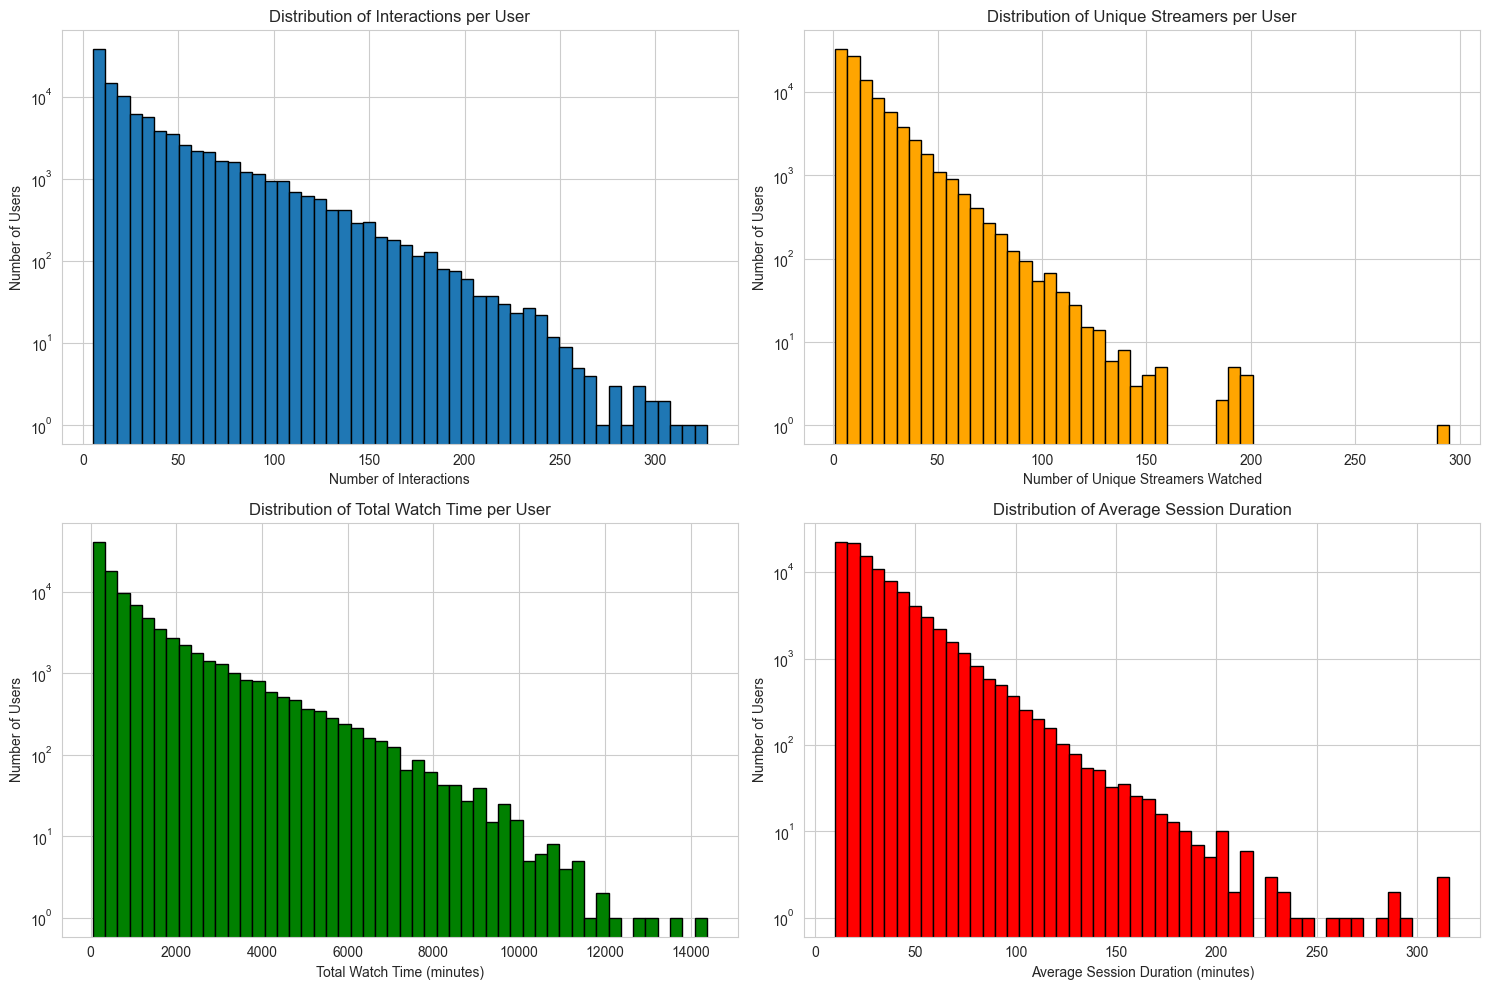

In [7]:
# Distribution of interactions per user
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Interactions per user
axes[0, 0].hist(user_stats['num_interactions'], bins=50, edgecolor='black')
axes[0, 0].set_xlabel('Number of Interactions')
axes[0, 0].set_ylabel('Number of Users')
axes[0, 0].set_title('Distribution of Interactions per User')
axes[0, 0].set_yscale('log')

# Unique streamers per user
axes[0, 1].hist(user_stats['num_streamers'], bins=50, edgecolor='black', color='orange')
axes[0, 1].set_xlabel('Number of Unique Streamers Watched')
axes[0, 1].set_ylabel('Number of Users')
axes[0, 1].set_title('Distribution of Unique Streamers per User')
axes[0, 1].set_yscale('log')

# Total watch time per user
axes[1, 0].hist(user_stats['total_watch_time'], bins=50, edgecolor='black', color='green')
axes[1, 0].set_xlabel('Total Watch Time (minutes)')
axes[1, 0].set_ylabel('Number of Users')
axes[1, 0].set_title('Distribution of Total Watch Time per User')
axes[1, 0].set_yscale('log')

# Average session duration
axes[1, 1].hist(user_stats['avg_session_duration'], bins=50, edgecolor='black', color='red')
axes[1, 1].set_xlabel('Average Session Duration (minutes)')
axes[1, 1].set_ylabel('Number of Users')
axes[1, 1].set_title('Distribution of Average Session Duration')
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()


In [ ]:
# Streamer-level statistics
streamer_stats = df.groupby('streamer').agg({
    'user_id': ['count', 'nunique'],
    'stream_id': 'nunique',
    'duration_minutes': ['sum', 'mean']
}).reset_index()

streamer_stats.columns = ['streamer', 'total_interactions', 'unique_viewers', 
                          'num_sessions', 'total_stream_time', 'avg_session_duration']

# Sort by popularity (unique viewers)
streamer_stats = streamer_stats.sort_values('unique_viewers', ascending=False).reset_index(drop=True)

print("Streamer statistics:")
print(streamer_stats.describe())
print("\nTop 20 most popular streamers:")
print(streamer_stats.head(20))


Streamer statistics:
       total_interactions  unique_viewers   num_sessions  total_stream_time  \
count       162625.000000   162625.000000  162625.000000       1.626250e+05   
mean            18.765460        9.255391       4.550291       5.896210e+02   
std            251.414758      100.916828       7.813506       7.722504e+03   
min              1.000000        1.000000       1.000000       1.000000e+01   
25%              1.000000        1.000000       1.000000       1.000000e+01   
50%              2.000000        1.000000       2.000000       4.000000e+01   
75%              5.000000        3.000000       4.000000       1.500000e+02   
max          45144.000000    17154.000000     358.000000       1.114940e+06   

       avg_session_duration  
count         162625.000000  
mean              26.966781  
std               25.082251  
min               10.000000  
25%               10.000000  
50%               20.000000  
75%               32.253521  
max              520.000000

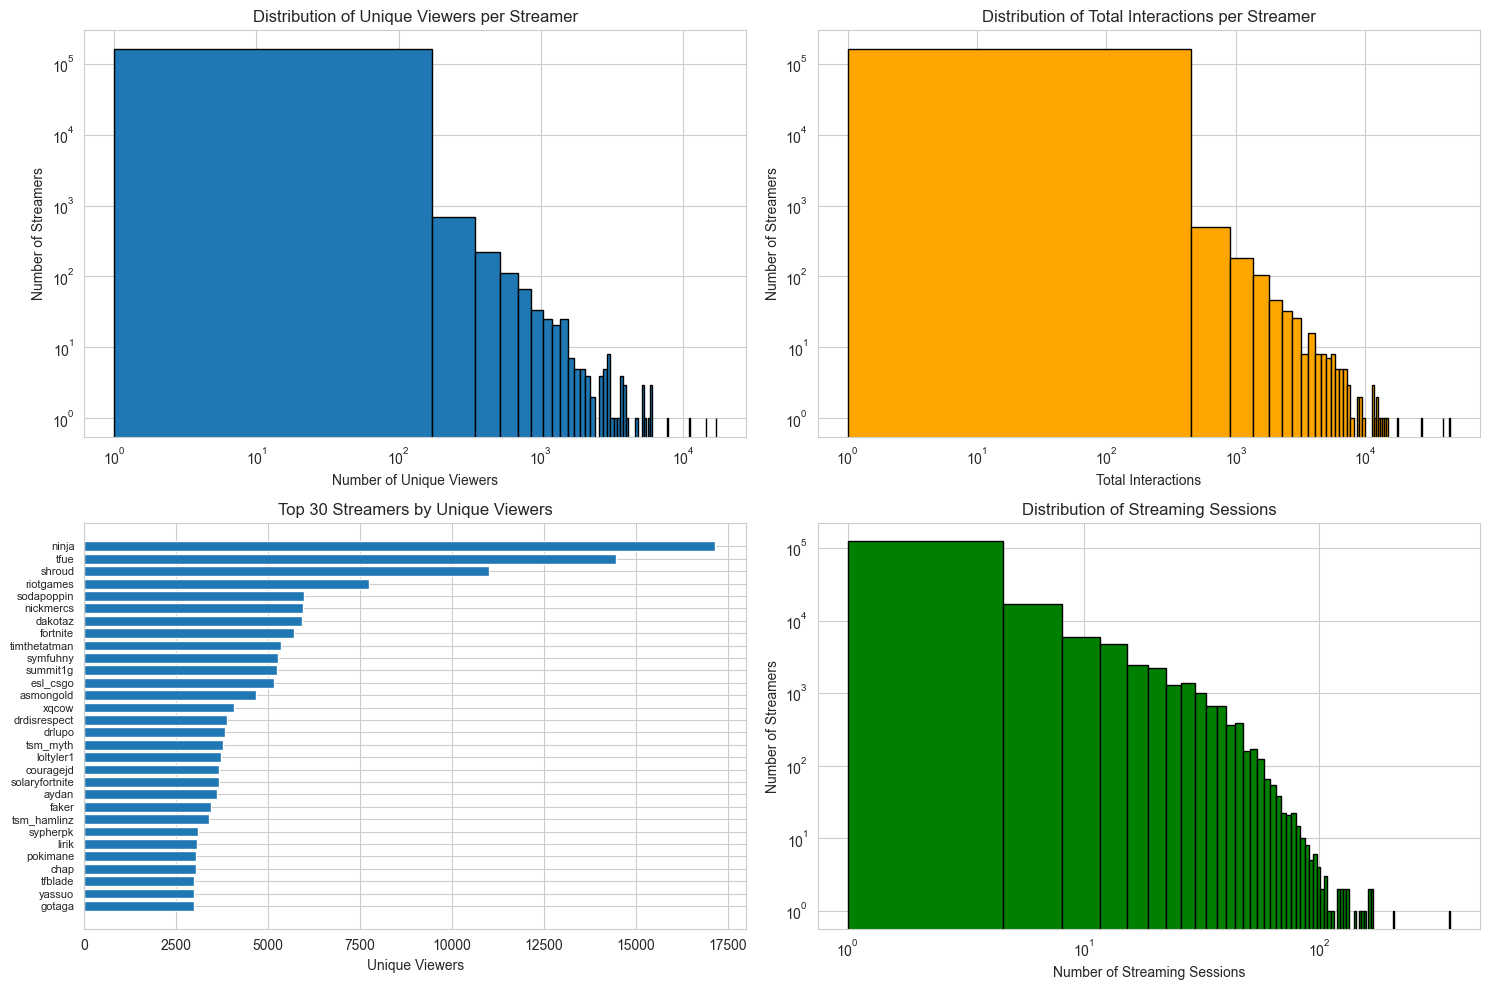

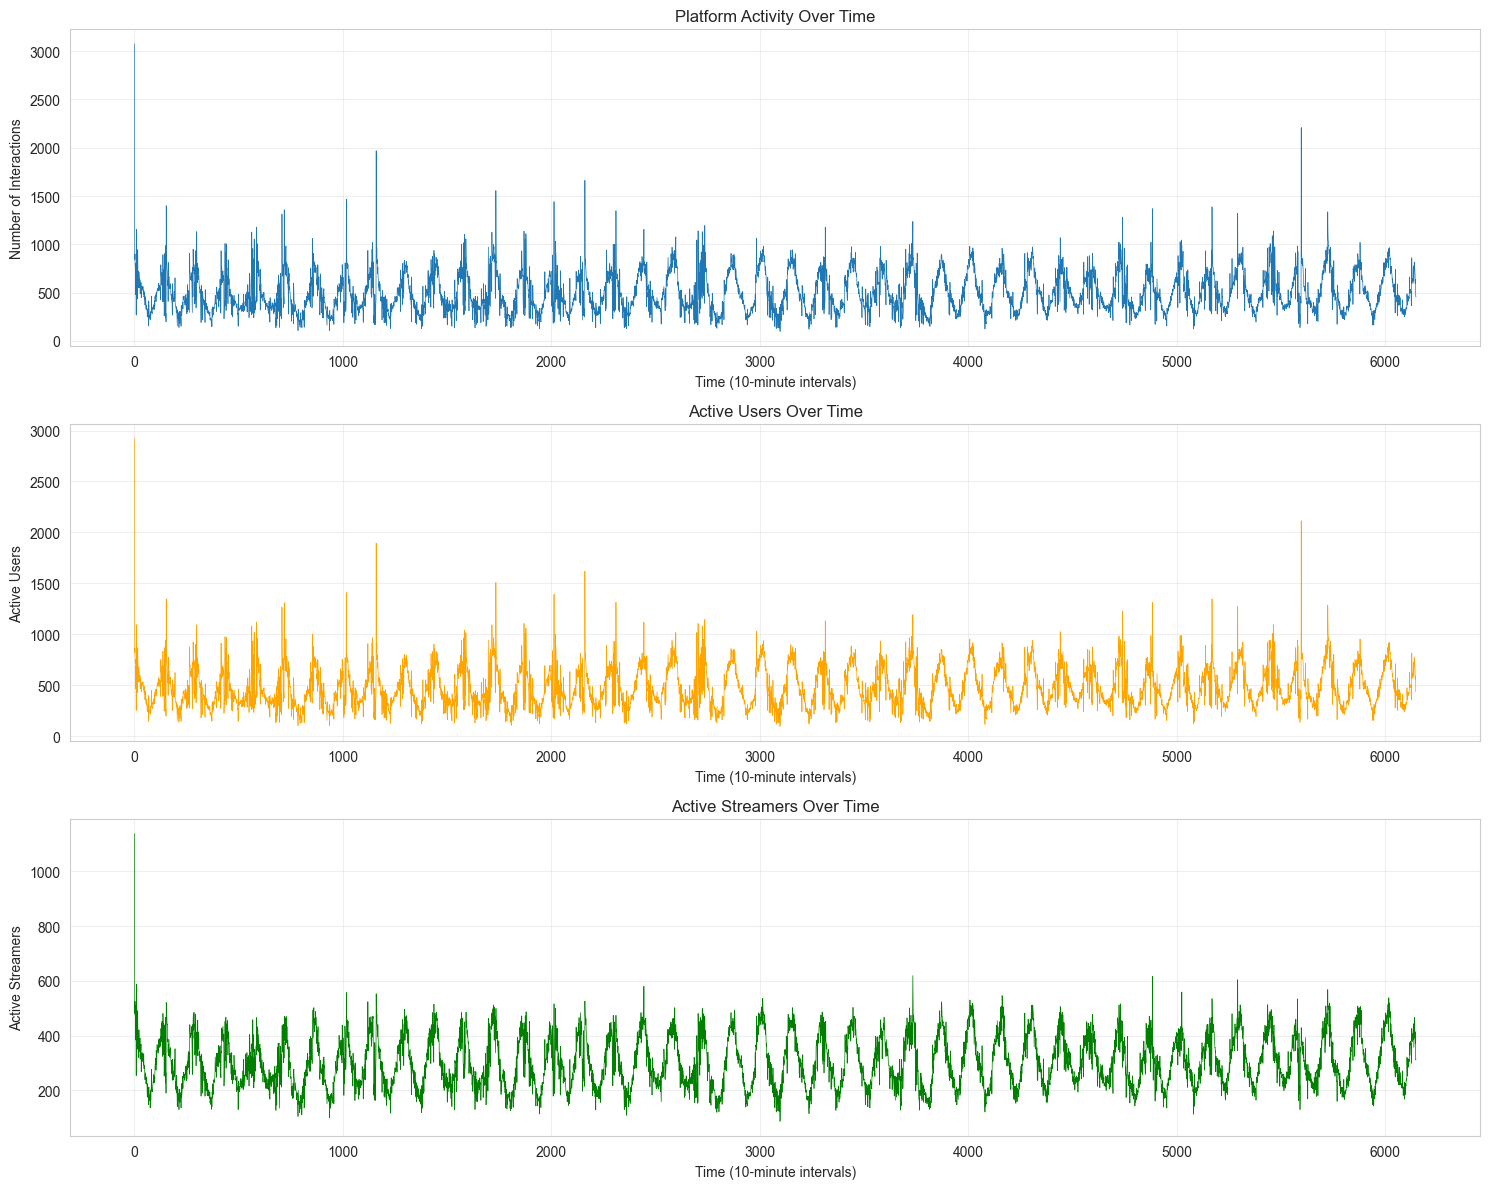

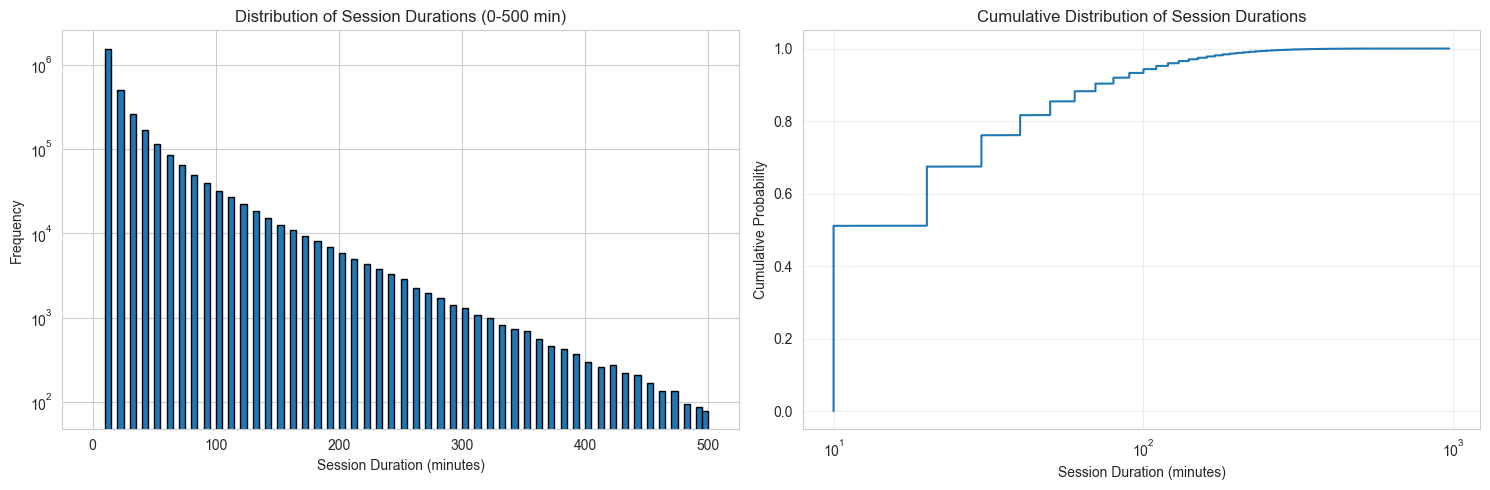

Session duration percentiles (minutes):
10th percentile: 10.00
25th percentile: 10.00
50th percentile: 10.00
75th percentile: 30.00
90th percentile: 70.00
95th percentile: 110.00
99th percentile: 220.00


In [13]:
# Analyze session durations
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall duration distribution
axes[0].hist(df['duration_minutes'], bins=100, edgecolor='black', range=(0, 500))
axes[0].set_xlabel('Session Duration (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Session Durations (0-500 min)')
axes[0].set_yscale('log')

# Cumulative distribution
durations_sorted = np.sort(df['duration_minutes'])
cumulative = np.arange(1, len(durations_sorted) + 1) / len(durations_sorted)
axes[1].plot(durations_sorted, cumulative)
axes[1].set_xlabel('Session Duration (minutes)')
axes[1].set_ylabel('Cumulative Probability')
axes[1].set_title('Cumulative Distribution of Session Durations')
axes[1].set_xscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print percentiles
print("Session duration percentiles (minutes):")
percentiles = [10, 25, 50, 75, 90, 95, 99]
for p in percentiles:
    print(f"{p}th percentile: {np.percentile(df['duration_minutes'], p):.2f}")


## 7. Interaction Patterns and Sparsity


In [15]:
# Calculate sparsity
num_users = df['user_id'].nunique()
num_streamers = df['streamer'].nunique()
num_interactions = len(df)
total_possible = num_users * num_streamers
sparsity = 1 - (num_interactions / total_possible)

print("=" * 60)
print("INTERACTION MATRIX CHARACTERISTICS")
print("=" * 60)
print(f"Users: {num_users:,}")
print(f"Streamers: {num_streamers:,}")
print(f"Actual interactions: {num_interactions:,}")
print(f"Possible interactions: {total_possible:,}")
print(f"Sparsity: {sparsity:.6f} ({sparsity*100:.4f}%)")
print(f"Density: {1-sparsity:.6f} ({(1-sparsity)*100:.4f}%)")


INTERACTION MATRIX CHARACTERISTICS
Users: 100,000
Streamers: 162,625
Actual interactions: 3,051,733
Possible interactions: 16,262,500,000
Sparsity: 0.999812 (99.9812%)
Density: 0.000188 (0.0188%)


Streamer diversity per user:
Mean: 15.05
Median: 10.00
Std: 14.78
Min: 1
Max: 295


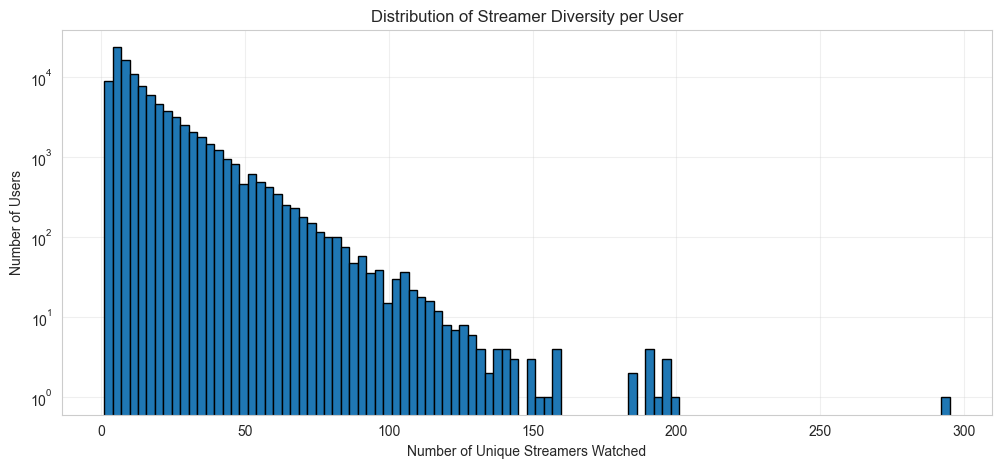

In [16]:
# Analyze how many streamers users watch on average
user_streamer_diversity = df.groupby('user_id')['streamer'].nunique()

print("Streamer diversity per user:")
print(f"Mean: {user_streamer_diversity.mean():.2f}")
print(f"Median: {user_streamer_diversity.median():.2f}")
print(f"Std: {user_streamer_diversity.std():.2f}")
print(f"Min: {user_streamer_diversity.min()}")
print(f"Max: {user_streamer_diversity.max()}")

plt.figure(figsize=(12, 5))
plt.hist(user_streamer_diversity, bins=100, edgecolor='black')
plt.xlabel('Number of Unique Streamers Watched')
plt.ylabel('Number of Users')
plt.title('Distribution of Streamer Diversity per User')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()


In [18]:
# Sample co-viewing analysis for top streamers
top_streamers = streamer_stats.head(10)['streamer'].tolist()

print("Top 10 streamers for co-viewing analysis:")
for i, s in enumerate(top_streamers, 1):
    print(f"{i}. {s}")

# Find users who watched these top streamers
top_streamer_users = df[df['streamer'].isin(top_streamers)].groupby('streamer')['user_id'].apply(set)

print("\nOverlap analysis for top 10 streamers:")
for i, s1 in enumerate(top_streamers[:5]):
    for s2 in top_streamers[i+1:6]:
        overlap = len(top_streamer_users[s1] & top_streamer_users[s2])
        jaccard = overlap / len(top_streamer_users[s1] | top_streamer_users[s2])
        print(f"{s1} <-> {s2}: {overlap} shared users (Jaccard: {jaccard:.4f})")


Top 10 streamers for co-viewing analysis:
1. ninja
2. tfue
3. shroud
4. riotgames
5. sodapoppin
6. nickmercs
7. dakotaz
8. fortnite
9. timthetatman
10. symfuhny

Overlap analysis for top 10 streamers:
ninja <-> tfue: 9131 shared users (Jaccard: 0.4061)
ninja <-> shroud: 3305 shared users (Jaccard: 0.1329)
ninja <-> riotgames: 1137 shared users (Jaccard: 0.0478)
ninja <-> sodapoppin: 1231 shared users (Jaccard: 0.0562)
ninja <-> nickmercs: 4562 shared users (Jaccard: 0.2460)
tfue <-> shroud: 2786 shared users (Jaccard: 0.1228)
tfue <-> riotgames: 836 shared users (Jaccard: 0.0391)
tfue <-> sodapoppin: 912 shared users (Jaccard: 0.0467)
tfue <-> nickmercs: 4512 shared users (Jaccard: 0.2838)
shroud <-> riotgames: 1599 shared users (Jaccard: 0.0932)
shroud <-> sodapoppin: 2401 shared users (Jaccard: 0.1645)
shroud <-> nickmercs: 1246 shared users (Jaccard: 0.0793)
riotgames <-> sodapoppin: 1266 shared users (Jaccard: 0.1016)
riotgames <-> nickmercs: 274 shared users (Jaccard: 0.0204)
soda

In [19]:
# Check for anomalies
print("Data Quality Checks:")
print("=" * 60)

# Negative or zero durations
negative_duration = df[df['duration'] <= 0]
print(f"Sessions with negative/zero duration: {len(negative_duration)} ({len(negative_duration)/len(df)*100:.2f}%)")

# Very long sessions (>24 hours)
very_long = df[df['duration_minutes'] > 1440]  # 24 hours
print(f"Sessions longer than 24 hours: {len(very_long)} ({len(very_long)/len(df)*100:.2f}%)")
print(f"  Max duration: {df['duration_minutes'].max():.2f} minutes ({df['duration_minutes'].max()/60:.2f} hours)")

# Very short sessions (<1 minute)
very_short = df[df['duration_minutes'] < 1]
print(f"Sessions shorter than 1 minute: {len(very_short)} ({len(very_short)/len(df)*100:.2f}%)")

# Duplicate rows
duplicates = df.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

# Users with only 1 interaction
single_interaction_users = (df.groupby('user_id').size() == 1).sum()
print(f"Users with only 1 interaction: {single_interaction_users} ({single_interaction_users/num_users*100:.2f}%)")

# Streamers with only 1 viewer
single_viewer_streamers = (df.groupby('streamer')['user_id'].nunique() == 1).sum()
print(f"Streamers with only 1 viewer: {single_viewer_streamers} ({single_viewer_streamers/num_streamers*100:.2f}%)")


Data Quality Checks:
Sessions with negative/zero duration: 0 (0.00%)
Sessions longer than 24 hours: 0 (0.00%)
  Max duration: 970.00 minutes (16.17 hours)
Sessions shorter than 1 minute: 0 (0.00%)
Duplicate rows: 0
Users with only 1 interaction: 0 (0.00%)
Streamers with only 1 viewer: 89656 (55.13%)


In [20]:
print("=" * 60)
print("COMPREHENSIVE SUMMARY STATISTICS")
print("=" * 60)
print("\n1. DATASET OVERVIEW")
print(f"   Total interactions: {len(df):,}")
print(f"   Unique users: {num_users:,}")
print(f"   Unique streamers: {num_streamers:,}")
print(f"   Time span: {df['time_stop'].max() - df['time_start'].min()} intervals (~{(df['time_stop'].max() - df['time_start'].min())*10/60/24:.1f} days)")
print(f"   Sparsity: {sparsity*100:.4f}%")

print("\n2. USER BEHAVIOR")
print(f"   Avg interactions per user: {user_stats['num_interactions'].mean():.2f}")
print(f"   Median interactions per user: {user_stats['num_interactions'].median():.2f}")
print(f"   Avg unique streamers per user: {user_stats['num_streamers'].mean():.2f}")
print(f"   Median unique streamers per user: {user_stats['num_streamers'].median():.2f}")
print(f"   Avg total watch time per user: {user_stats['total_watch_time'].mean():.2f} min ({user_stats['total_watch_time'].mean()/60:.2f} hrs)")

print("\n3. STREAMER STATISTICS")
print(f"   Avg unique viewers per streamer: {streamer_stats['unique_viewers'].mean():.2f}")
print(f"   Median unique viewers per streamer: {streamer_stats['unique_viewers'].median():.2f}")
print(f"   Avg interactions per streamer: {streamer_stats['total_interactions'].mean():.2f}")
print(f"   Most popular streamer: {streamer_stats.iloc[0]['streamer']} ({streamer_stats.iloc[0]['unique_viewers']:.0f} viewers)")

print("\n4. SESSION CHARACTERISTICS")
print(f"   Avg session duration: {df['duration_minutes'].mean():.2f} min")
print(f"   Median session duration: {df['duration_minutes'].median():.2f} min")
print(f"   Std session duration: {df['duration_minutes'].std():.2f} min")

print("\n5. POWER LAW CHARACTERISTICS")
print(f"   Top 1% of streamers attract {streamer_stats.head(int(num_streamers*0.01))['unique_viewers'].sum()/num_users*100:.2f}% of unique users")
print(f"   Top 10% of streamers have {streamer_stats.head(int(num_streamers*0.1))['total_interactions'].sum()/len(df)*100:.2f}% of interactions")

print("=" * 60)


COMPREHENSIVE SUMMARY STATISTICS

1. DATASET OVERVIEW
   Total interactions: 3,051,733
   Unique users: 100,000
   Unique streamers: 162,625
   Time span: 6148 intervals (~42.7 days)
   Sparsity: 99.9812%

2. USER BEHAVIOR
   Avg interactions per user: 30.52
   Median interactions per user: 16.00
   Avg unique streamers per user: 15.05
   Median unique streamers per user: 10.00
   Avg total watch time per user: 958.87 min (15.98 hrs)

3. STREAMER STATISTICS
   Avg unique viewers per streamer: 9.26
   Median unique viewers per streamer: 1.00
   Avg interactions per streamer: 18.77
   Most popular streamer: ninja (17154 viewers)

4. SESSION CHARACTERISTICS
   Avg session duration: 31.42 min
   Median session duration: 10.00 min
   Std session duration: 42.58 min

5. POWER LAW CHARACTERISTICS
   Top 1% of streamers attract 790.15% of unique users
   Top 10% of streamers have 85.64% of interactions


User Engagement Segmentation:
                 user_id num_interactions          num_streamers  \
                   count             mean min  max          mean   
engagement_level                                                   
Casual              8446         5.000000   5    5      3.762491   
Regular            39654         9.480128   6   15      6.346068   
Active             33163        28.651358  16   50     15.179537   
Power User         18737        89.844319  51  327     38.337727   

                 total_watch_time  
                             mean  
engagement_level                   
Casual                 140.605020  
Regular                280.051697  
Active                 893.675783  
Power User            2879.725676  


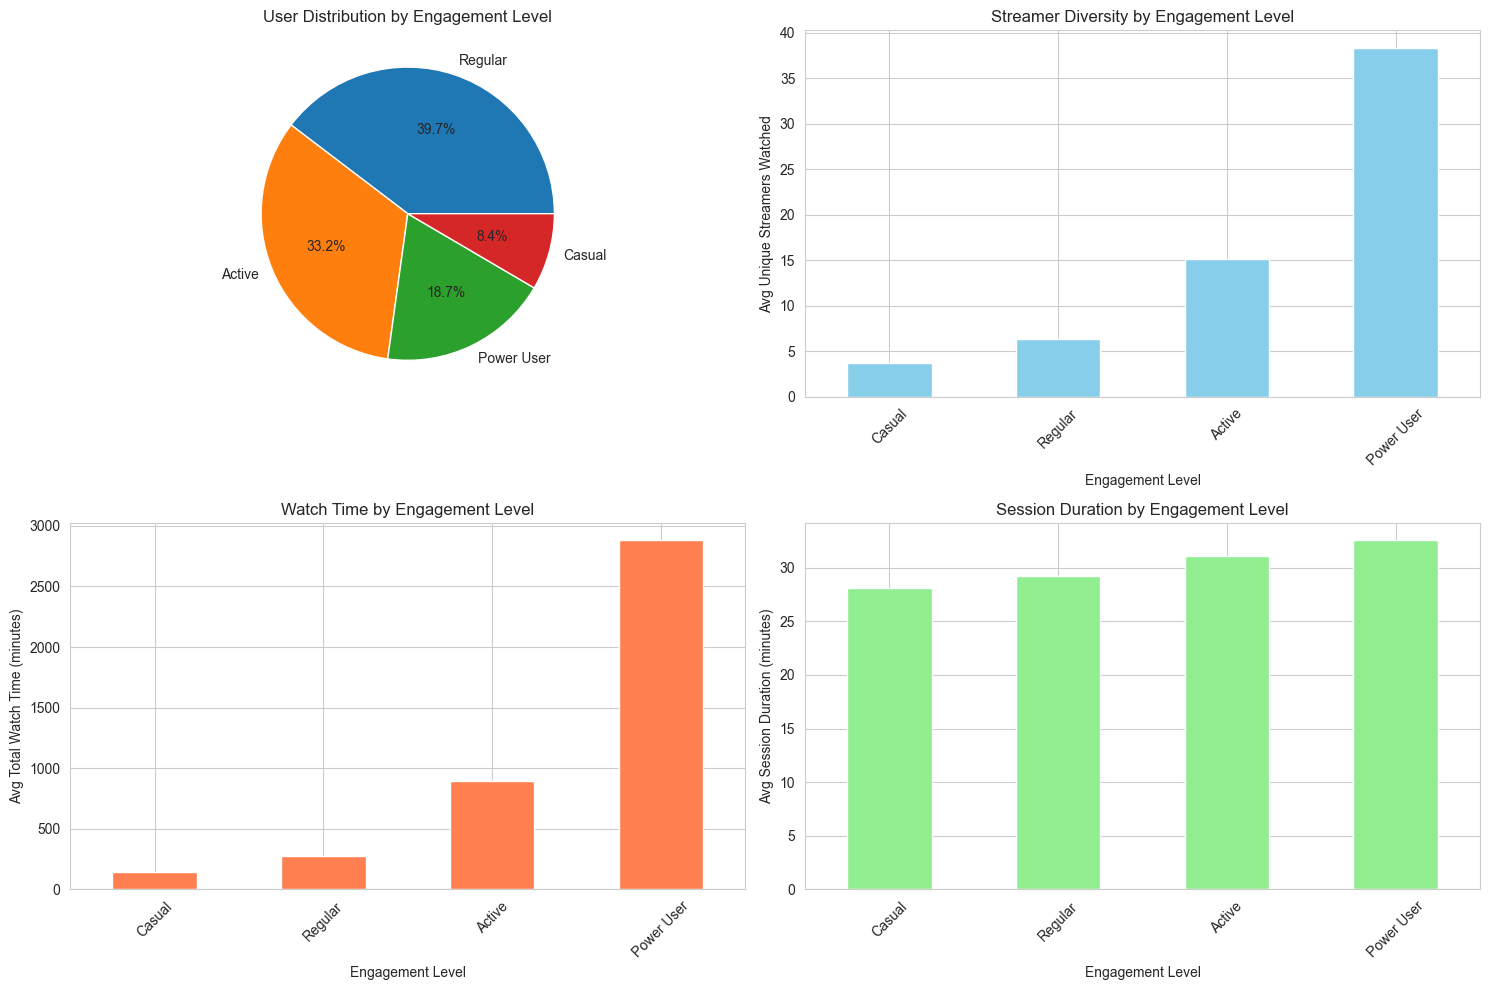


Key Insights:
- Power users (18737 users, 18.7%) watch 38.3 streamers on average
- Casual users make up 8.4% of the user base


Streamer Popularity Tiers:
                streamer unique_viewers             total_interactions  \
                   count           mean  min    max                sum   
popularity_tier                                                          
Micro             148054       2.029219    1     10             465081   
Small              10687      21.880696   11     50             418288   
Medium              2796      96.131259   51    200             537088   
Large               1088     645.314338  201  17154            1631276   

                num_sessions  
                        mean  
popularity_tier               
Micro               2.749767  
Small              18.667072  
Medium             32.829041  
Large              38.227941  

% of Total Interactions by Tier:
  Micro: 15.2% of interactions from 148,054 streamers (91.0% of streamers)
  Small: 13.7% of interactions from 10,687 streamers (6.6% of streamers)
  Medium: 17.6% of interactions from 2,796 streamers (1

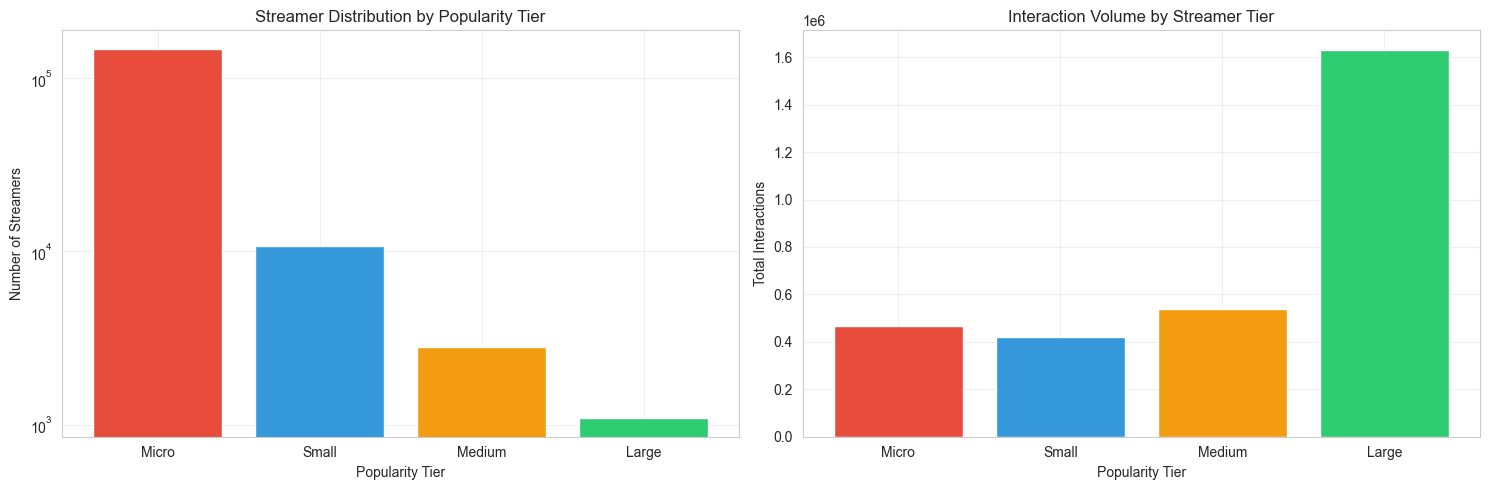

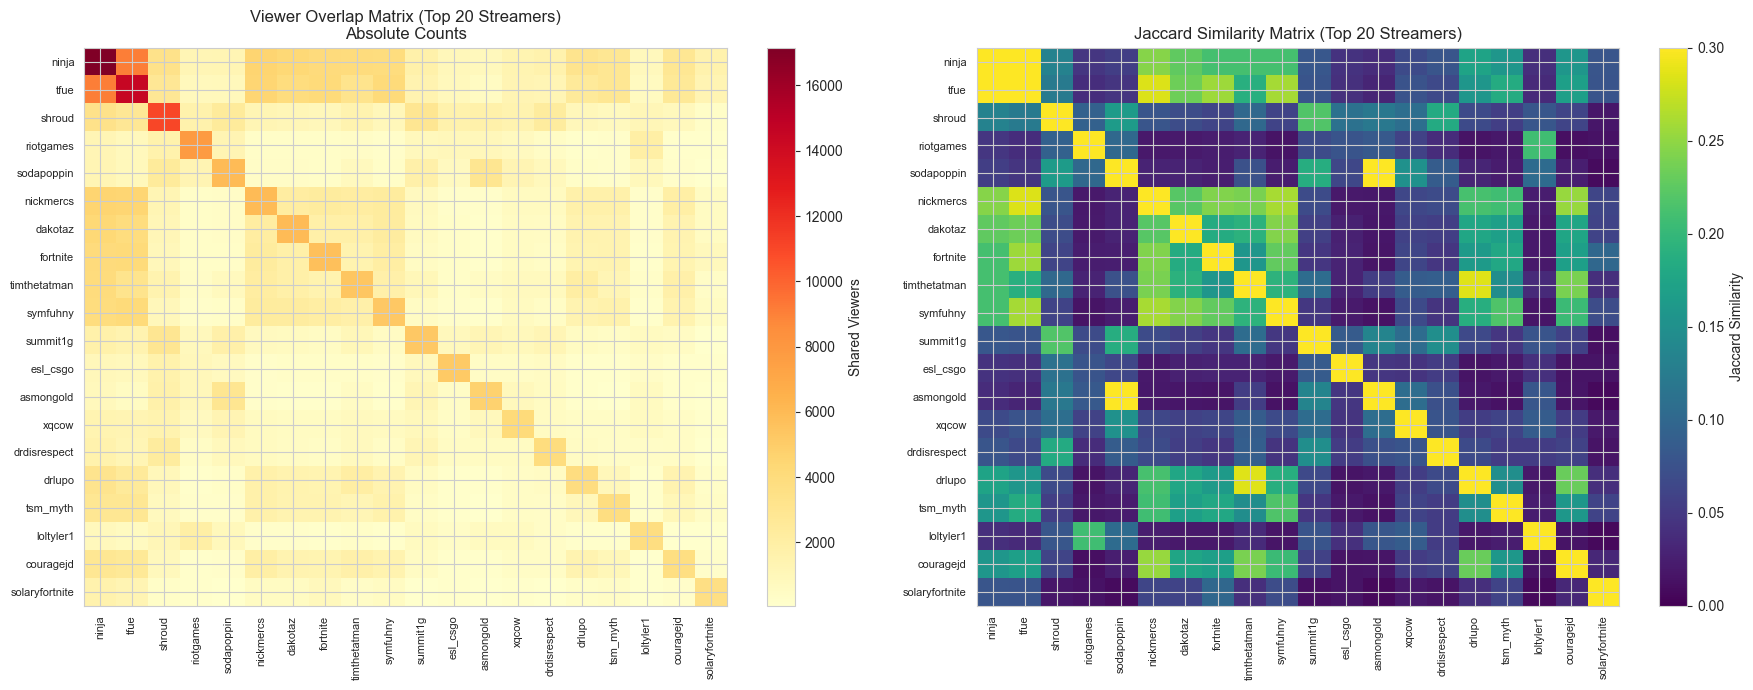


Top 10 Most Similar Streamer Pairs (by Jaccard):
1. ninja <-> tfue
   Jaccard: 0.4061 | Shared viewers: 9131
2. sodapoppin <-> asmongold
   Jaccard: 0.3886 | Shared viewers: 2983
3. timthetatman <-> drlupo
   Jaccard: 0.2856 | Shared viewers: 2043
4. tfue <-> nickmercs
   Jaccard: 0.2838 | Shared viewers: 4512
5. nickmercs <-> symfuhny
   Jaccard: 0.2609 | Shared viewers: 2321
6. tfue <-> symfuhny
   Jaccard: 0.2599 | Shared viewers: 4068
7. tfue <-> fortnite
   Jaccard: 0.2564 | Shared viewers: 4118
8. nickmercs <-> couragejd
   Jaccard: 0.2537 | Shared viewers: 1949
9. ninja <-> nickmercs
   Jaccard: 0.2460 | Shared viewers: 4562
10. dakotaz <-> symfuhny
   Jaccard: 0.2438 | Shared viewers: 2196

Average Jaccard similarity among top 20: 0.0960
This indicates moderate audience overlap


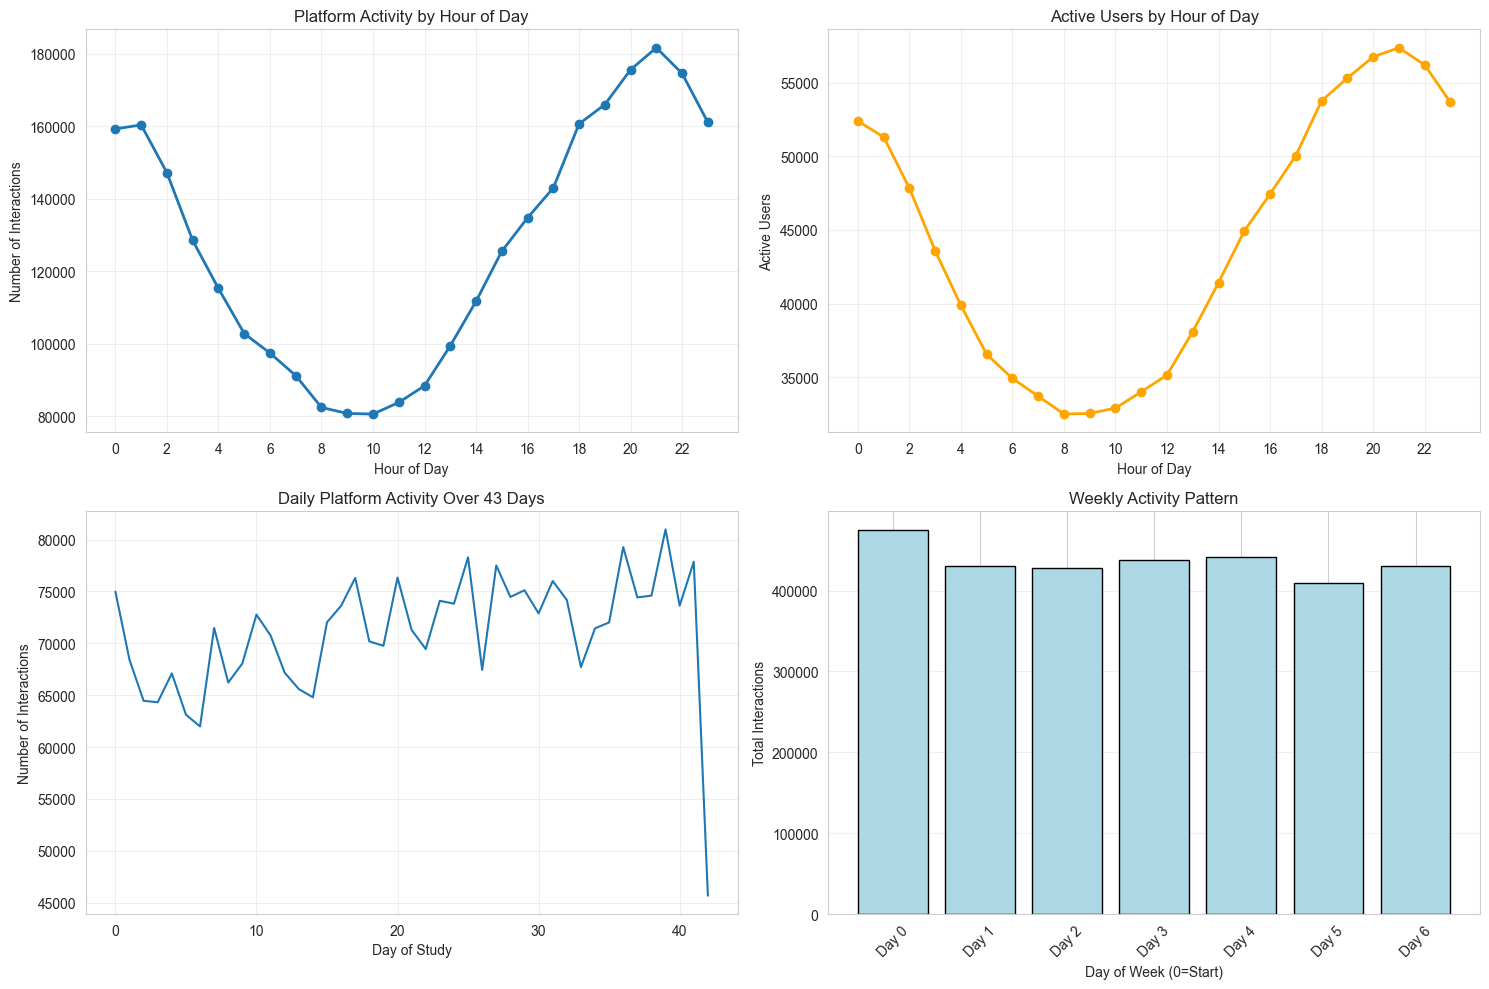


Temporal Insights:
- Peak activity hour: 21:00 (181,716 interactions)
- Lowest activity hour: 10:00 (80,542 interactions)
- Peak/Low ratio: 2.26x


ValueError: cannot insert user_id, already exists

Streamer Hopping Behavior:
Total user transitions: 2,951,733
Streamer hops (within 30 min): 567,920
Hop rate: 19.24%

Top 15 Most Common Streamer Transitions:
  ninja → timthetatman: 540 times
  ninja → tfue: 524 times
  timthetatman → ninja: 496 times
  ninja → drlupo: 409 times
  tfue → nickmercs: 389 times
  fortnite → tfue: 341 times
  tfue → ninja: 333 times
  nickmercs → tfue: 276 times
  shroud → summit1g: 258 times
  timthetatman → drlupo: 246 times
  tfue → fortnite: 237 times
  ninja → reverse2k: 235 times
  drlupo → ninja: 234 times
  cloakzy → timthetatman: 228 times
  drlupo → timthetatman: 228 times


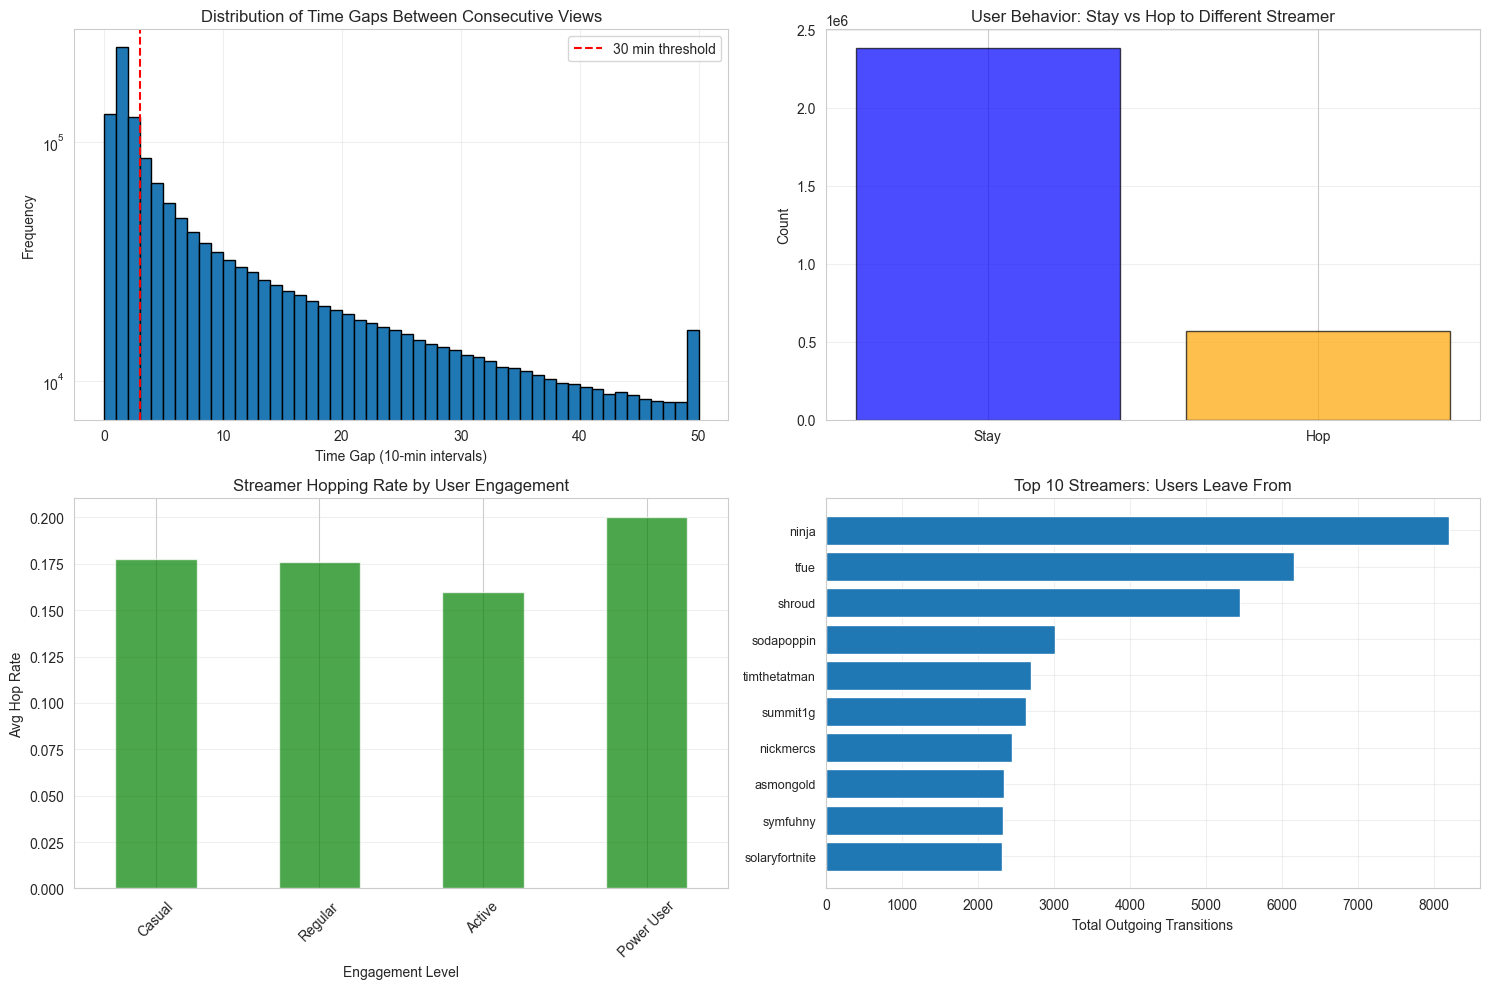


Insight for Sequential Models:
The 19.24% hop rate suggests moderate sequential dependencies
This supports using sequential/Markov models for Part 1


CRITICAL INSIGHTS FOR PART 3: STREAMER SIMILARITY & COMMUNITY DISCOVERY

1. DATA CHARACTERISTICS:
   ✓ Extreme sparsity (99.9812%) requires efficient sparse matrix operations
   ✓ Power law distribution: focus on top 16,262 streamers for meaningful similarities
   ✓ 100,000 users watching average 15.1 streamers

2. CO-VIEWING PATTERNS:
   ✓ Average Jaccard similarity among top 20: 0.0960
   ✓ Strong overlaps exist between popular streamers → good for similarity metrics
   ✓ Network effects visible → collaborative filtering should work well

4. SEQUENTIAL PATTERNS:
   ✓ 19.24% streamer hop rate
   ✓ Users do explore multiple streamers → diverse recommendations needed
   ✓ Transition network exists → can use for graph-based methods

5. RECOMMENDATIONS FOR PART 3:
   ✓ Filter threshold: Use MIN_STREAMER_VIEWERS >= 5-10 to reduce noise
   ✓ Similarity metrics: Cosine + Jaccard both appropriate given overlap patterns
   ✓ Clustering: Expect 10-30 meaningful clusters based on diversity
   ✓ 